In [1]:
!pip install git+https://github.com/htygithub/pymr

  Running command git clone -q https://github.com/htygithub/pymr 'C:\Users\FOR108~1\AppData\Local\Temp\pip-req-build-oo2nsyjo'
You should consider upgrading via the 'D:\Users\For108student\Anaconda3\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/htygithub/pymr to c:\users\for108~1\appdata\local\temp\pip-req-build-oo2nsyjo
  Created wheel for pymr: filename=pymr-0.0.2-py3-none-any.whl size=117149 sha256=f9ec8ce69dd9abde69390091ae14e8a230e90c6e5bf77ae6ecd5c3f8d9b73374
  Stored in directory: C:\Users\FOR108~1\AppData\Local\Temp\pip-ephem-wheel-cache-iukb8wu5\wheels\f1\1b\0d\15e1a5108eda08fbb1a8270b03c5924c142f378e53107dc058
Successfully built pymr


In [1]:
import glob
ffs = glob.glob(r'C:\Users\For108student\Desktop\OpenDataset\Testing\**\*_gt.nii.gz')

In [2]:
import nibabel
import numpy as np
from pymr.heart import ahaseg
import matplotlib.pyplot as plt


In [3]:

def get_slice_label(heart4d):
    heart = heart4d.copy()
    curve3 = np.sum(heart==3, axis=(0, 1, 3))
    curve2 = np.sum(heart==2, axis=(0, 1, 3))
    curve1 = np.sum(heart==1, axis=(0, 1, 3))

    curve_and = (curve3 > 0) & (curve2 > 0) & (curve1 > 0)
    curve_or = (curve3 > 0) | (curve2 > 0) | (curve1 > 0)
    curve_and = curve_and.astype(np.int)
    curve_or = curve_or.astype(np.int)
    curve_diff = curve_or-curve_and
    slice_label = curve_and * 0
    curve_apex = curve_diff.copy()
    curve_apex[:curve_apex.size//2] = 0
    curve_basal = curve_diff.copy()
    curve_basal[curve_apex.size//2:] = 0
    #curve_apex = curve_apex * 4
    
    loc = dict()
    if np.sum(curve_apex) > 0:
        #got_apex = True    
        loc[3] = [1]*1 + [2]*1 + [3]*1
        loc[4] = [1]*1 + [2]*2 + [3]*1
        loc[5] = [1]*2 + [2]*2 + [3]*1
        loc[6] = [1]*2 + [2]*2 + [3]*2
        loc[7] = [1]*2 + [2]*3 + [3]*2
        loc[8] = [1]*3 + [2]*3 + [3]*2
        loc[9] = [1]*3 + [2]*3 + [3]*3
        loc[10] = [1]*3 + [2]*4 + [3]*3
        loc[11] = [1]*4 + [2]*4 + [3]*3
        loc[12] = [1]*4 + [2]*4 + [3]*4
        loc[13] = [1]*4 + [2]*5 + [3]*4
        loc[14] = [1]*5 + [2]*5 + [3]*4
        loc[15] = [1]*5 + [2]*5 + [3]*5
        loc[16] = [1]*5 + [2]*6 + [3]*5
        loc[17] = [1]*6 + [2]*6 + [3]*5
        loc[18] = [1]*6 + [2]*6 + [3]*6
        loc[19] = [1]*6 + [2]*7 + [3]*6
        loc[20] = [1]*7 + [2]*7 + [3]*6
    else:
        loc[3] = [1]*1 + [2]*1 + [3]*1
        loc[4] = [1]*1 + [2]*1 + [3]*1 + [4]*1
        loc[5] = [1]*1 + [2]*2 + [3]*1 + [4]*1
        loc[6] = [1]*2 + [2]*2 + [3]*1 + [4]*1
        loc[7] = [1]*2 + [2]*2 + [3]*2 + [4]*1
        loc[8] = [1]*2 + [2]*3 + [3]*2 + [4]*1
        loc[9] = [1]*3 + [2]*3 + [3]*2 + [4]*1
        loc[10] = [1]*3 + [2]*3 + [3]*3 + [4]*1
        loc[11] = [1]*3 + [2]*3 + [3]*3 + [4]*2
        loc[12] = [1]*3 + [2]*4 + [3]*3 + [4]*2
        loc[13] = [1]*4 + [2]*4 + [3]*3 + [4]*2
        loc[14] = [1]*4 + [2]*4 + [3]*4 + [4]*2
        loc[15] = [1]*4 + [2]*4 + [3]*4 + [4]*3
        loc[16] = [1]*4 + [2]*5 + [3]*4 + [4]*3
        loc[17] = [1]*5 + [2]*5 + [3]*4 + [4]*3
        loc[18] = [1]*5 + [2]*5 + [3]*5 + [4]*3
        loc[19] = [1]*5 + [2]*6 + [3]*5 + [4]*3
        loc[20] = [1]*6 + [2]*6 + [3]*5 + [4]*3
        
    slice_label[curve_and > 0] = loc[np.sum(curve_and)]
    slice_label[curve_apex > 0] = 4
    slice_label[curve_basal > 0] = 5
    return slice_label

In [18]:
def convert(f, result_dir):
    temp = nibabel.load(f)
    heart = temp.get_fdata()
    affine = temp.affine
    
    reverse = np.median(np.diff(np.sum(heart, axis=(0,1,3)))) > 0
    if reverse:
        heart = heart[:,:, ::-1, :]    
    slice_label = get_slice_label(heart)
    #print(slice_label)
    offset = dict()
    offset[1] = 0
    offset[2] = 6
    offset[3] = 12

    count = -1
    heart_aha17_4d = heart  * 0
    for ii in range(slice_label.size):
        #print(ii)
        #print(slice_label[ii])
        count = count + 1
        if (slice_label[ii] == 0) or (slice_label[ii] == 5):
            continue

        if slice_label[ii] == 4:
            temp = heart[:, :, ii, :].copy()
            temp[temp==2] = 17
            temp[temp==1] = 0
            temp[temp==3] = 0
            heart_aha17_4d[:, :, ii, :] = temp
            continue


        heart_xyt = heart[:, :, ii, :].copy()

        curve = np.sum(heart_xyt, axis=(0, 1))
        dia_frame = np.argmax(curve)
        curve[curve==0] = 1e20
        sys_frame = np.argmin(curve)
        #print(dia_frame, sys_frame)
        heart_xy_dia = heart_xyt[..., dia_frame]
        heart_xy_sys = heart_xyt[..., sys_frame]
        if slice_label[ii] == 3:
            nseg = 4
        else:
            nseg = 6

        if (np.sum(heart_xy_dia==3) < 5) or (np.sum(heart_xy_sys==3) < 5):
            slice_label[ii] = 5
            continue


        dia_seg = ahaseg.get_seg((heart_xy_dia==1, heart_xy_dia==2, heart_xy_dia==3), nseg)
        sys_seg = ahaseg.get_seg((heart_xy_sys==1, heart_xy_sys==2, heart_xy_sys==3), nseg)

        dia_seg[dia_seg > 0] = dia_seg[dia_seg > 0] + offset[slice_label[ii]]
        sys_seg[sys_seg > 0] = sys_seg[sys_seg > 0] + offset[slice_label[ii]]

        heart_aha17_4d[:, :, ii, dia_frame] = dia_seg
        heart_aha17_4d[:, :, ii, sys_frame] = sys_seg

    #print('reverse:', reverse)
    if reverse:
        heart_aha17_4d = heart_aha17_4d[:,:, ::-1, :]
        
    result_f = join(result_dir, basename(f))
        
    nii_label = nibabel.Nifti1Image(heart_aha17_4d.astype(np.uint8), affine)
    nibabel.save(nii_label, result_f)
    #print(dia_frame, sys_frame)

In [19]:
from os.path import join, basename
import tqdm

result_dir = r'N:\jiayi\AHASEG-master\data\Training_labeled'

for f in tqdm.tqdm(ffs):
    try:
        convert(f, result_dir)
    except Exception:
        print('error:', basename(f))
        print('='*10)
        print(Exception)
        


  7%|█████▉                                                                           | 10/136 [00:25<05:36,  2.67s/it]

error: A5D0G0_sa_gt.nii.gz
<class 'Exception'>



 24%|███████████████████                                                              | 32/136 [01:20<03:09,  1.82s/it]

error: B6I0T4_sa_gt.nii.gz
<class 'Exception'>



 41%|█████████████████████████████████▎                                               | 56/136 [02:20<03:29,  2.62s/it]

error: E4I9O7_sa_gt.nii.gz
<class 'Exception'>



 90%|███████████████████████████████████████████████████████████████████████▊        | 122/136 [05:10<00:26,  1.88s/it]C:\Users\For108student\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



 90%|████████████████████████████████████████████████████████████████████████▎       | 123/136 [05:12<00:24,  1.90s/it]

error: P3T5U1_sa_gt.nii.gz
<class 'Exception'>



100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [05:48<00:00,  2.57s/it]


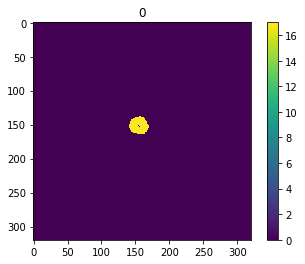

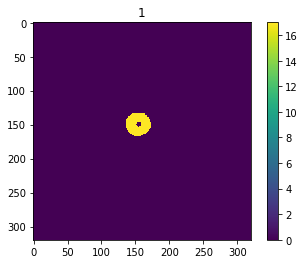

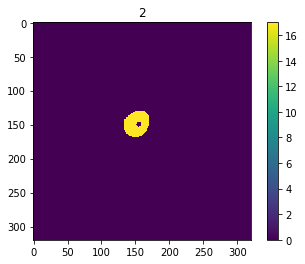

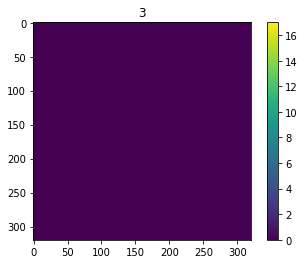

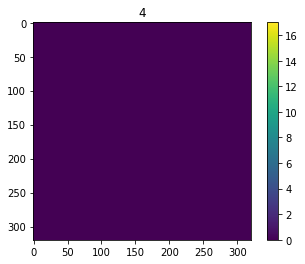

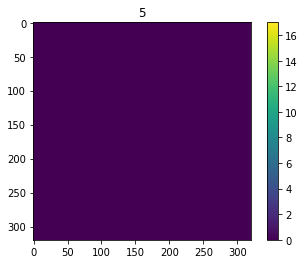

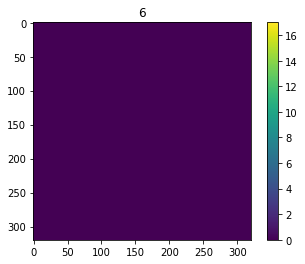

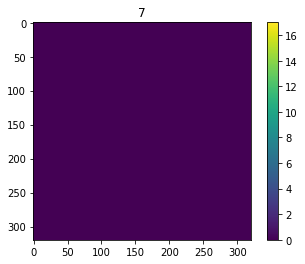

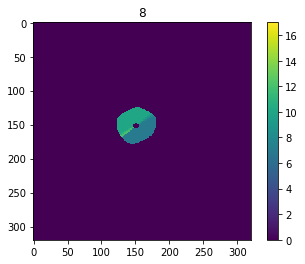

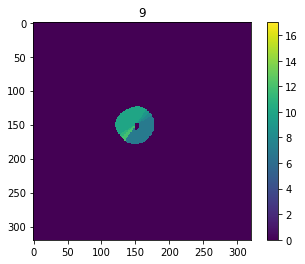

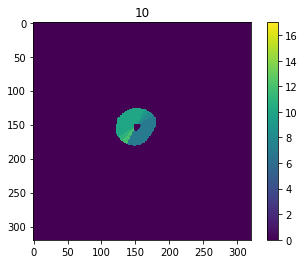

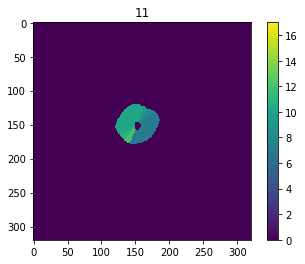

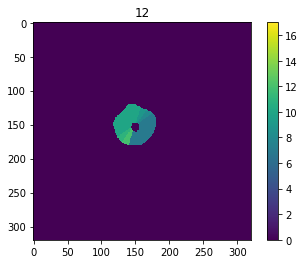

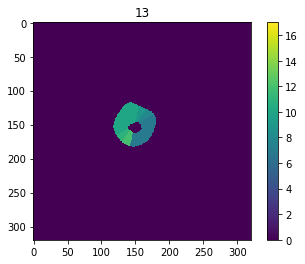

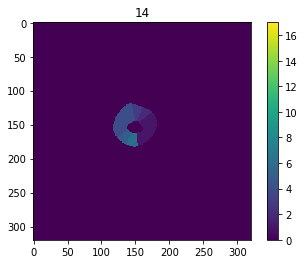

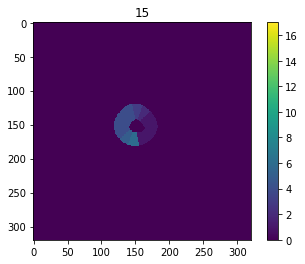

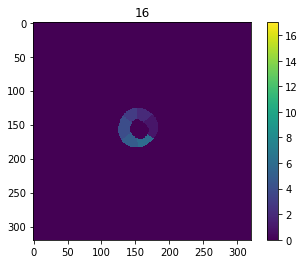

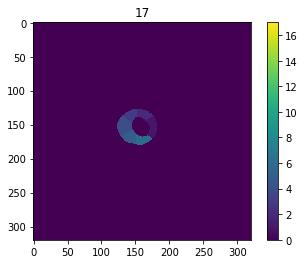

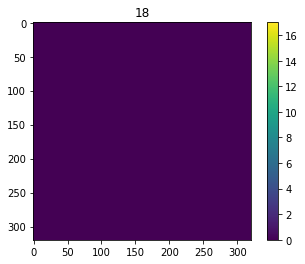

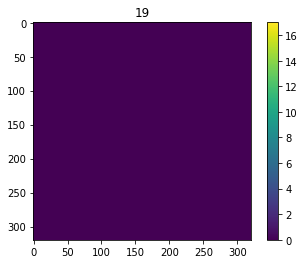

In [86]:
for ii in range(heart_aha17_4d.shape[2]):
    plt.figure()
    plt.title(ii)
    plt.imshow(heart_aha17_4d[:, :, ii, dia_frame], vmin=0, vmax=17)
    plt.colorbar()


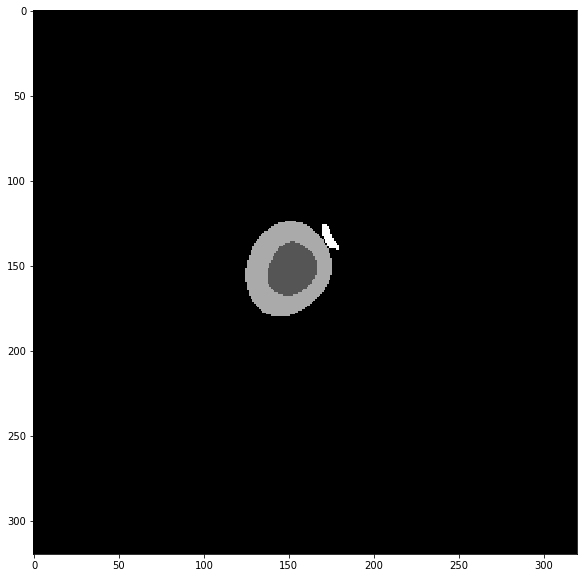

In [67]:
plt.figure(figsize=(10,10))
plt.imshow(heart_xy_sys, cmap='gray')

In [53]:
np.nonzero(heart_xy_sys==3)

(array([130, 130, 131], dtype=int64), array([173, 174, 174], dtype=int64))

In [88]:
sys_frame

29

In [89]:
dia_frame

9